# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных

import scipy.stats as stats

# делаем визуальную настройку графиков
%matplotlib inline
sns.set_palette("Set2") 
sns.set_theme(style="dark")

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

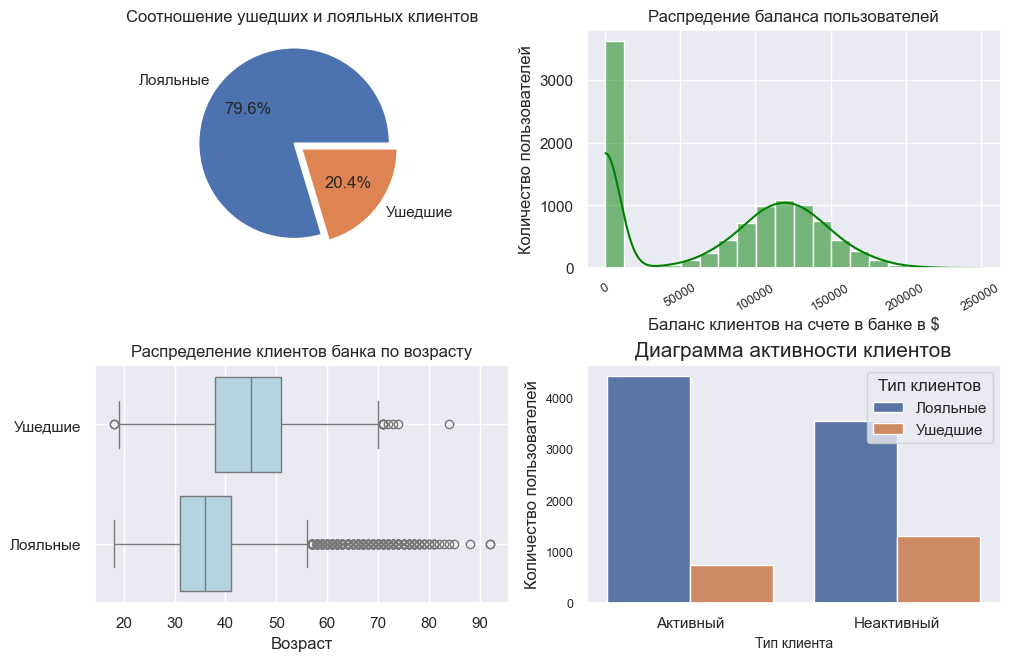

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6.5), constrained_layout=True)

Exited_data = churn_data['Exited'].apply(lambda x: 'Ушедшие' if x==1 else 'Лояльные')
Exited_data = Exited_data.value_counts()

axes[0,0].pie(Exited_data,
         labels = Exited_data.index,
         explode = [0.1, 0],
         autopct='%.1f%%')
axes[0,0].set_title('Соотношение ушедших и лояльных клиентов');

sns.histplot(data=churn_data,
            x = 'Balance',
            bins=20,
            color = 'green',
            ax = axes[0,1],
            kde=True)
axes[0,1].set_title('Распредение баланса пользователей', fontsize = 12);
axes[0,1].set_xlabel('Баланс клиентов на счете в банке в $', size = 12)
axes[0,1].set_ylabel('Количество пользователей')
axes[0,1].xaxis.set_tick_params(rotation = 30, labelsize = 9)
axes[0,1].grid();

churn_data['Loyalty'] = churn_data['Exited'].apply(lambda x: 'Ушедшие' if x==1 else 'Лояльные')

boxplt = sns.boxplot(data=churn_data,
                     x='Age',
                     y='Loyalty',
                     orient='h',
                     color='lightblue',
                     ax=axes[1,0])
axes[1,0].set_title('Распределение клиентов банка по возрасту')
axes[1,0].set_xlabel("Возраст")
axes[1,0].set_ylabel("")
axes[1,0].grid()

churn_data['Активность'] = churn_data['IsActiveMember'].apply(lambda x: 'Активный' if x==1 else 'Неактивный')
grupped2 = churn_data.groupby(by='Loyalty')['Активность'].value_counts().reset_index(name='counts')

barplt = sns.barplot(data=grupped2,
                     x='Активность',
                     y='counts',
                     hue='Loyalty',
                     ax=axes[1,1])

axes[1,1].set_title("Диаграмма активности клиентов", fontsize = 15);
axes[1,1].set_xlabel('Тип клиента', size = 10)
axes[1,1].set_ylabel('Количество пользователей')
axes[1,1].yaxis.set_tick_params(labelsize = 9)
axes[1,1].legend(title='Тип клиентов');



В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [4]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 16)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [5]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname', 'Loyalty', 'Активность'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [6]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [7]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [8]:
# Создаем новые признаки
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/churn_data['Age']

# Иcпользуем get_dummies для кодирования тестового признака Gender
churn_data = pd.get_dummies(churn_data, drop_first=True)
display(churn_data.head(3))

# Выводим описательные характеристики получившегося датасета
display(churn_data.describe())



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,False
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,True
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,True


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [9]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [10]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [12]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [13]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

alpha = 0.05
        
# С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.
for col in churn_data.columns:
    result = stats.shapiro(churn_data[col])
    print(col, ':')
    decision_normality(result[1])
    print('-'*100)

CreditScore :
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
----------------------------------------------------------------------------------------------------
Age :
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
----------------------------------------------------------------------------------------------------
Tenure :
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
----------------------------------------------------------------------------------------------------
Balance :
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
----------------------------------------------------------------------------------------------------
NumOfProducts :
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нор

Все рассматриваемые признаки не распределены нормально, поэтому займемся их нормализацией. Поскольку мы не удаляли выбросы, оптимально будет использовать RobustScaler

In [14]:
scaler = preprocessing.RobustScaler()

# Обучаем Scaler на тренировочной выборке
scaler.fit(X_train)

# Применяем трансформацию к тренировочной и тестовой выборкам
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

 *В описанной задаче важно одновременно:*

- *Минимизировать ложноположительные срабатывания — чтобы не тратить ресурсы колл-центра на клиентов, которые на самом деле не собираются уходить (снизить количество ненужных звонков). За это отвечается метрика precision*

- *Минимизировать ложноотрицательные срабатывания — чтобы не пропустить клиентов с высоким риском оттока и сохранить их. За это отвечает метрика recall*.

Таким образом, при ограниченных ресурсах важно найти баланс между ***precision*** и ***recall***, чтобы эффективно использовать колл-центр и максимально сохранить клиентов. Лучше всего с такой задачей справится ***F1-мера*** - гармоническое среднее между ***precision*** и ***recall***. ЕЕ максимум достигается, когда максимальны обе метрики.


### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [15]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42,
    max_iter=1000    
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print('TRAIN '+'-'*47, metrics.classification_report(y_train, y_train_pred), sep='\n')
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print('TEST '+'-'*48, metrics.classification_report(y_test, y_test_pred), sep='\n')

TRAIN -----------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.43      0.51       610

    accuracy                           0.73      1881
   macro avg       0.70      0.65      0.66      1881
weighted avg       0.72      0.73      0.72      1881

TEST ------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       424
           1       0.60      0.42      0.50       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.71       628



Наша искомая метрика F1 на тестовых данных для категории ушедших клиентов (значение 1) выдает 0.50. По условию задачи, это считается удовлетворительным значением. К сожалению это значени не удалось улучшить с помощью регуляризации(подставлял разные значения C, но метрика становилась только ниже). Вероятно у данной модели нет переобучения, поэтому регуляризация не увеличила метрику. Думаю, дальше стоит поработать над оптимизацией порога классификации (*threshold*), а также попробовать усложнить саму модель.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)

#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)

#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 454)
(628, 454)


In [17]:
import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')

#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    penalty='l2',
    C=0.4,
    random_state=42,
    max_iter=10000    
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_poly.predict(X_train_poly)
#Вывод отчет о метриках классификации
print('TRAIN '+'-'*47, metrics.classification_report(y_train, y_train_pred), sep='\n')
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_poly.predict(X_test_poly)
#Вывод отчет о метриках классификации
print('TEST '+'-'*48, metrics.classification_report(y_test, y_test_pred), sep='\n')

TRAIN -----------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1271
           1       0.82      0.71      0.76       610

    accuracy                           0.86      1881
   macro avg       0.85      0.82      0.83      1881
weighted avg       0.85      0.86      0.85      1881

TEST ------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       424
           1       0.70      0.61      0.65       204

    accuracy                           0.79       628
   macro avg       0.76      0.74      0.75       628
weighted avg       0.78      0.79      0.78       628



При разных видах регуляризации и разных коэффициентах C получаются приблизительно одни и те же значения метрики F1 (0.76 на трейне и 0.65 на тесте для признака ушеднего клиента - 1). Отсутствие изменений F1 при варьировании C и типе регуляризации — признак того, что либо модель уже оптимальна для текущих данных, а также, что нам удалось избежать переобучения. Также заметно улучшение самой метрики с 0.5 для полинома первой степени - до 0.65 для полинома 3ей степени. Но усложнив модель (а у нас получилось более 450 признаков) мы увеличили время обучения модели.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

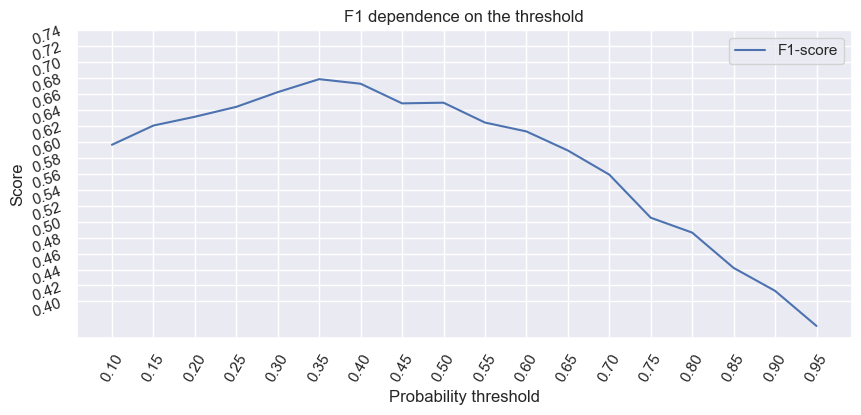

In [18]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой и тренировочнойвыборки
y_train_proba_pred = log_reg_poly.predict_proba(X_train_poly)[:, 1]
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = (y_test_proba_pred > threshold).astype(int)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_poly)# код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
    

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
ax.set_yticks(np.arange(0.4, 0.75, 0.02)) 
#Отображаем легенду
ax.xaxis.set_tick_params(rotation=60)
ax.yaxis.set_tick_params(rotation=20)
ax.grid(linestyle='-')
ax.legend();

Из полученного графика видно, что наибольшее значение на тестовых данных метрика F1 достигает при значении threshold равном 0.35

In [19]:
# Задаём оптимальный порог вероятностей
threshold_opt = 0.35

# Подставляем значение порога вероятности, равное 0.35
y_train_pred_opt = (y_train_proba_pred > threshold_opt).astype(int)
y_test_pred_opt = (y_test_proba_pred > threshold_opt).astype(int)

#Вывод отчет о метриках классификации
print('TRAIN', metrics.classification_report(y_train, y_train_pred_opt), sep='\n')
print('TEST', metrics.classification_report(y_test, y_test_pred_opt), sep='\n')

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1271
           1       0.71      0.81      0.76       610

    accuracy                           0.83      1881
   macro avg       0.81      0.83      0.82      1881
weighted avg       0.84      0.83      0.84      1881

TEST
              precision    recall  f1-score   support

           0       0.86      0.79      0.83       424
           1       0.63      0.74      0.68       204

    accuracy                           0.77       628
   macro avg       0.75      0.76      0.75       628
weighted avg       0.79      0.77      0.78       628



С помощью различных преобразований модели и подбора оптимального порога вероятности нам удалось сократить разрыв между значениями метрики F1 для тренировочных и тестовых данных (для признака 1 - ушедший клиент). Разрыв для значений метрики около 8%(на трейне-  0.76, на тесте — 0.68) — это хороший результат, учитывая, что данные несбалансированы. Улучшение видно налицо - изначально искомая метрика была 0.5, а мы увелили ее до 0.68 на тестовых данных

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [21]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
# Создадим объект класса DecisionTreeClassifier()
tree_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Обучем модель
tree_model.fit(X_train, y_train)

# Делаем предсказание
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)

# Вычисляем метрики
print(f'F1-мера на тренировочной выборке: {metrics.f1_score(y_train, y_pred_train):.2f}')
print(f'F1-мера на тестовой выборке: {metrics.f1_score(y_test, y_pred_test):.2f}')

F1-мера на тренировочной выборке: 1.00
F1-мера на тестовой выборке: 0.53


*Вывод: модель сильно переобучена.*
- F1 на тренировке равен 1, что является максимально возможным значением. Это говорит о том, что модель идеально, запомнила тренировочные данные.

- На тестовых данных метрика равна 0.52, что кстати близко к значению для самой первой модели линейной регрессии. Такая большая разница между метриками для трейна и для теста показывает, что модель плохо обобщается на новые, невидимые данные.

*Такое поведение модели характерно для переобучения, когда модель «запоминает» шум и детали тренировочной выборки, вместо того чтобы выучить общие закономерности.*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
# Создадим объект класса DecisionTreeClassifier()
tree_model_v2 = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=8, # глубина
    min_samples_leaf=10 # минимальное число объектов в листе
)

# Обучем модель
tree_model_v2.fit(X_train, y_train)

# Делаем предсказание
y_pred_train = tree_model_v2.predict(X_train)
y_pred_test = tree_model_v2.predict(X_test)

# Вычисляем метрики
print(f'F1-мера на тренировочной выборке: {metrics.f1_score(y_train, y_pred_train):.2f}')
print(f'F1-мера на тестовой выборке: {metrics.f1_score(y_test, y_pred_test):.2f}')

F1-мера на тренировочной выборке: 0.72
F1-мера на тестовой выборке: 0.65


Вывод: 
* После добавления дополнительных параметров в модель дерева решений удалось добиться более сбалансированных результатов. Разница между метрикой на тесте и на трейне невелика, поэтому можно сделать вывод, что на этот раз нам удалось избежать переобучения модели.
* На тесте мы получили такую же метрику, что и в задании 5.5, равную 0.65. Но в случае с линейной регрессией мы сделали куда больше преобразований, чтобы получить такие результаты. Тем более, что метрика на трейне у линейной регрессии получилась немного больше (0.76 против 0.72). Это может говорить о том, что с такими данными для решения этой задачи больше подходит метод Дерева Решений.
* Добавив всего 2 параметра в модель мы смогли увеличить тестовую метрику с 0.53 до 0.65. Это существенное улучшение. Тем более, что для нашей задачи метрика, большая или равная 0.5, уже считается удовлетворительным результатом.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
forest_model = ensemble.RandomForestClassifier(
    n_estimators=500,  # число деревьев   
    max_depth=8, # глубина
    criterion='entropy', # критерий информативности
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42
)

# Обучем модель
forest_model.fit(X_train, y_train)

# Делаем предсказание
y_pred_train = forest_model.predict(X_train)
y_pred_test = forest_model.predict(X_test)

# Вычисляем метрики
print(f'F1-мера на тренировочной выборке: {metrics.f1_score(y_train, y_pred_train):.2f}')
print(f'F1-мера на тестовой выборке: {metrics.f1_score(y_test, y_pred_test):.2f}')

F1-мера на тренировочной выборке: 0.73
F1-мера на тестовой выборке: 0.64


В целом, показатели остались примерно на том же уровне, что говорит о том, что ансамбль Random Forest стабилен и не приводит к значительному переобучению.
Усложнив модель, мы рассчитывали на улучшение тестовой метрики, но она даже немного понизилась. Это значит, что модель для одиночного дерева решений весьма хорошо справилась со своей задачей и избежала серьезного переобучения, поскольку ансамбль Random Forest в виду своей структуры не должен сильно переобучаться, а метрики этиъ моделей практически идентичны.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

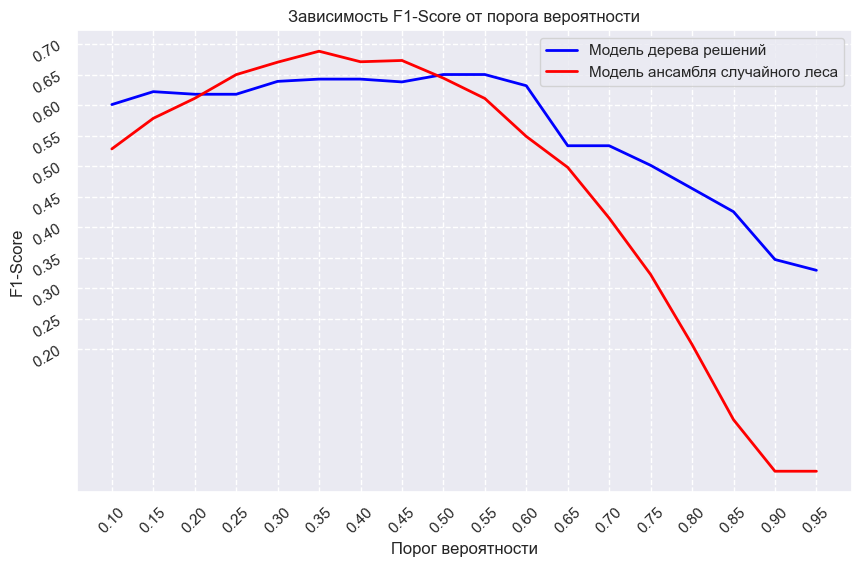

In [25]:
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)

# Предсказанные вероятности для модели дерева решений
y_test_proba_tree = tree_model_v2.predict_proba(X_test)[:, 1]
scores_tree = []
for threshold in thresholds:
    y_test_pred = (y_test_proba_tree > threshold).astype(int)
    score = metrics.f1_score(y_test, y_test_pred)
    scores_tree.append(score)

# Предсказанные вероятности для модели случайного леса
y_test_proba_forest = forest_model.predict_proba(X_test)[:, 1]
scores_forest = []
for threshold in thresholds:
    y_test_pred = (y_test_proba_forest > threshold).astype(int)
    score = metrics.f1_score(y_test, y_test_pred)
    scores_forest.append(score)

# Создаём фигуру и одну координатную плоскость
fig, ax = plt.subplots(figsize=(10, 6))

# Строим графики с разными цветами и метками для легенды
ax.plot(thresholds, scores_tree, color='blue', label='Модель дерева решений', linewidth=2)
ax.plot(thresholds, scores_forest, color='red', label='Модель ансамбля случайного леса', linewidth=2)

# Настраиваем оси и сетку
ax.set_title('Зависимость F1-Score от порога вероятности')
ax.set_xlabel('Порог вероятности')
ax.set_ylabel('F1-Score')
ax.set_xticks(thresholds)
ax.set_yticks(np.arange(0.2, 0.75, 0.05))
ax.xaxis.set_tick_params(rotation=45)
ax.yaxis.set_tick_params(rotation=30)
ax.grid(linestyle='--')
ax.legend();

In [26]:
# Задаём оптимальный порог вероятностей
threshold_opt = 0.35
y_train_proba_forest = forest_model.predict_proba(X_train)[:, 1]
y_test_proba_forest = forest_model.predict_proba(X_test)[:, 1]

# Подставляем значение порога вероятности, равное 0.35
y_train_pred_opt = (y_train_proba_forest > threshold_opt).astype(int)
y_test_pred_opt = (y_test_proba_forest > threshold_opt).astype(int)

#Вывод отчет о метриках классификации
print('TRAIN '+'-'*47, metrics.classification_report(y_train, y_train_pred_opt), sep='\n')
print('TEST '+'-'*48, metrics.classification_report(y_test, y_test_pred_opt), sep='\n')

TRAIN -----------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1271
           1       0.73      0.80      0.76       610

    accuracy                           0.84      1881
   macro avg       0.81      0.83      0.82      1881
weighted avg       0.84      0.84      0.84      1881

TEST ------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       424
           1       0.63      0.76      0.69       204

    accuracy                           0.78       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.78      0.78       628



Поскольку метрики по моделям древа решений и ансамбля случайного леса были очень близкими, то я принял решения визуализировать оба варианта, и это оказалось правильным решением. При стандартном значении порога вероятности, равным 0.5, значения метрик, действительно очень близки. Но также видно, что максимальное значение метрики для модели древа решений не превышает 0.65, когда как у ансамбля максимум приблизительно равен 0.7 и он достигается при значении порога вероятности, равному 0.35. Получается, что при усложнении модели и правильном выборе порога вероятности, нам все-таки удалось увеличить значение $F_1$-метрики.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

*Поскольку метрики, которые мы получили в заданиях 5.6 и 8.4 достаточно близки, то сделаем предсказание обеими моделями: для полиномиальной линейной регрессии и для ансамбля случайного леса, а после сравним их.*

In [27]:
Vasya_data = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Создаем новые признаки
Vasya_data['BalanceSalaryRatio'] = Vasya_data['Balance']/Vasya_data['EstimatedSalary']
Vasya_data['TenureByAge'] = Vasya_data['Tenure']/Vasya_data['Age']
Vasya_data['CreditScoreGivenAge'] = Vasya_data['CreditScore']/Vasya_data['Age']
# Иcпользуем get_dummies для кодирования тестового признака Gender
Vasya_data = pd.get_dummies(Vasya_data)

# Произведем нормализацию
Vasya_data_scaled = scaler.transform(Vasya_data)
Vasya_data_poly = poly.transform(Vasya_data_scaled)

y_forest_predict_proba = np.round(forest_model.predict_proba(Vasya_data),2)
y_poly_predict_proba = np.round(log_reg_poly.predict_proba(Vasya_data_poly),2)

print(f'Вектор вероятностей для клиента Василия от модели ансамбля случайного леса: {y_forest_predict_proba}')
print(f'Вектор вероятностей для клиента Василия от модели полиномиальной линейной регрессии: {y_poly_predict_proba}')


Вектор вероятностей для клиента Василия от модели ансамбля случайного леса: [[0.38 0.62]]
Вектор вероятностей для клиента Василия от модели полиномиальной линейной регрессии: [[0.44 0.56]]


*Наши модели имеют приблизительно одинаковые вектора вероятностей для клиента Василия. Но все же у первой вероятности чуть более отдалены от 0.5*

In [28]:
y_forest_predict = forest_model.predict(Vasya_data)
y_poly_predict = log_reg_poly.predict(Vasya_data_poly)

def check_exite(result, model_name):
    if int(result)==1:
        print(f'По мнению {model_name} клиент Василий откажется от услуг банка')
    else:
        print(f'По мнению {model_name} клиент продолжит пользоваться услугами банка')
        
check_exite(y_forest_predict, 'модели ансамбля случайного леса')
check_exite(y_poly_predict, 'модели полиномиальной регрессии')


По мнению модели ансамбля случайного леса клиент Василий откажется от услуг банка
По мнению модели полиномиальной регрессии клиент Василий откажется от услуг банка


*Обе модели сделали один и тот же вывод о том, что данный клиент перестанет пользоваться услугами банка. Это значит, что сотрудникам колл-центра стоит уделить ему внимание и сделать предложение, которое побудит его остаться.*

In [29]:
# Посмотрим также на предсказания других моделей из практической работы

check_exite(log_reg.predict(Vasya_data_scaled), 'линейной регресиии')
check_exite(tree_model.predict(Vasya_data), 'модели древа решений')
check_exite(tree_model_v2.predict(Vasya_data), 'модели древа решений 2ой версии')

По мнению линейной регресиии клиент продолжит пользоваться услугами банка
По мнению модели древа решений клиент Василий откажется от услуг банка
По мнению модели древа решений 2ой версии клиент Василий откажется от услуг банка


Как мы видим, все модели, кроме самой первой, смогли предсказать отток клиента